## Mathematical Morphology 

**Paper:** [An automated mathematical morphology driven algorithm for water body extraction from remotely sensed images](https://www.sciencedirect.com/science/article/abs/pii/S0924271618302338)

The paper proposes an automated algorithm to extract water bodies from remotely sensed images based on mathematical morphology concepts. The study is originally carried out using 5 datasets with spatial resolutions varying from 0.8m to 30m (CARTOSAT-1, CARTOSAT-2, Resourcesat-1, IRS P6 and Landsat-5). The outputs are then compared with an index approach using NDWI and MNDWI. 

For this exercise only a Landsat-8 (30m) image were used to identiy the water bodies in the region of the Lake Lanier, Georgia-USA (same used in the paper). The original algorithm was implemented in Matlab, but the authors do not refer to any repository where it could be found. 

The paper's algorithm is well described in page 15. It consists on the following steps:

1. Registration, radiometric correction & orthorectification of imagery if required
2. If image is noisy, then preprocessing operations such as Median filtering 
3. If spatial resolution of the image is known by the user than assign one of three proposed structural element (SE) size (they do not say the sizes). Else if the user choose dynamic selection of the size. Else proceed if the default optimal SE size. 
4. Top-hat and bottom-hat computations (original image + top-hat - botom-hat)
5. Opening
6. Dilation
7. Gray thresholding and binarization
8. Closing

The steps 1 and 2 were skipped since we are using a Landat Level-2 image. 

In [1]:
import rasterio
from rasterio import plot
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat,black_tophat,square)
from skimage.filters import threshold_otsu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

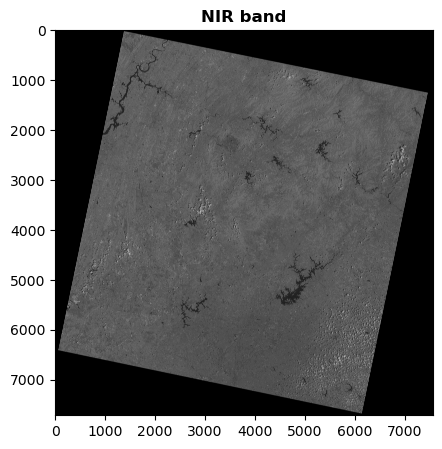

<AxesSubplot:title={'center':'NIR band'}>

In [2]:
# Study Area
with rasterio.open('LC08_L2SP_019036_20210728_20210804_02_T1_SR_B5.TIF','r') as data:
    b5 = np.squeeze(data.read())  
    
plt.subplots(figsize=(5,5))
plot.show(b5, cmap='gray',title='NIR band')


### Morphological Approach

Note: Try SE = 10 in the block if resolution >= 20 to observe sharper results in the top-hat and bottom-hat intermediate results

In [3]:
def water_body_extraction(file_path:str) -> np.array:
    """
    Extracts water bodies based on Morphological Operations
    """ 
    data = rasterio.open(file_path)
    
    #Structural Element size (se) - The authors set the upper-bound to the SE size to less than 20 pixels (but no exact size was given in the paper)
    resolution = data.transform[0]
    
    if resolution >= 20:
        se = 3
    elif resolution >= 10:
        se = 4
    else:
        se = 5 
        
    image = np.squeeze(data.read())  
        
    kernel = square(se) #for mediam-low resoultion

    # Top-hat (White tophat) & Bottom-hat (Black tophat)
    top_hat = white_tophat(image, kernel)
    bottom_hat = black_tophat(image, kernel)

    f2 = (image + top_hat - bottom_hat)

    # Opening 
    f3 = opening(f2, kernel)

    # Morphological
    f4 = dilation(f3,kernel)

    # Gray thresholding and binarization 
    thresh = threshold_otsu(image)
    f5 = image > thresh

    # Closing
    f6 = closing(f5,kernel)
    
    return top_hat, bottom_hat,f2,f3,f4,f5,f6

def plot_comparison(original:np.array, 
                    final_output:np.array,
                    title:str, 
                    title_one:str='NIR Band',
                    cmap:str='gray') -> plt.show:
    """
    Plot comparison between two images
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
    ax1.imshow(b5,cmap='gray')
    ax1.set_title(title_one)
    ax2.imshow(final_output,cmap=cmap)
    ax2.set_title(title)
    plt.show()

In [4]:
# Intermediate results
top_hat, bottom_hat,white_bottom_hat, openend, dilated, binary, final_output = water_body_extraction('LC08_L2SP_019036_20210728_20210804_02_T1_SR_B5.TIF')

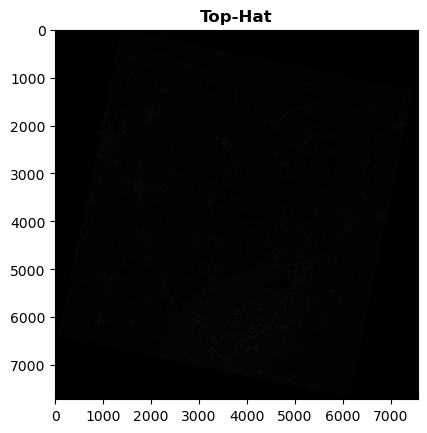

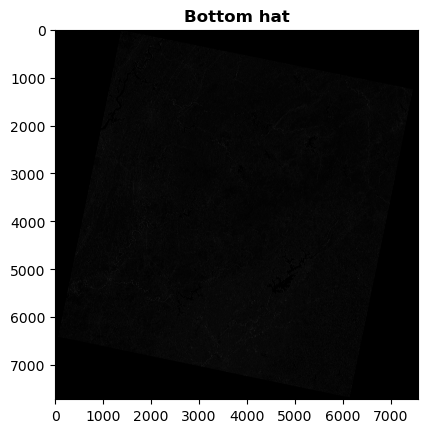

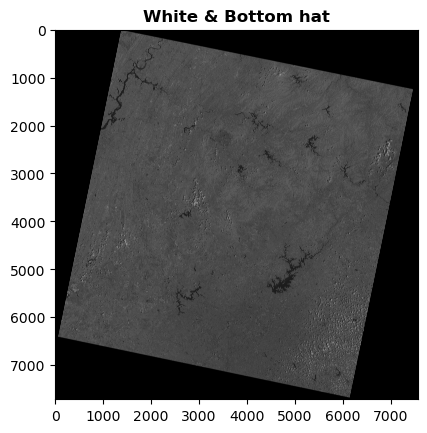

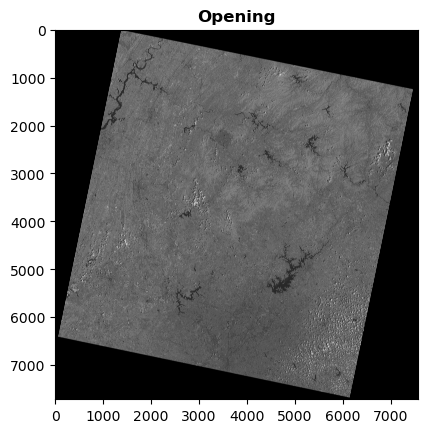

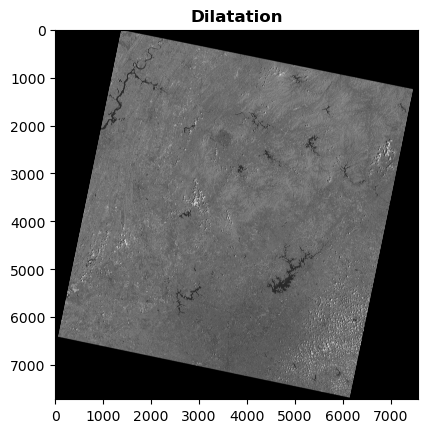

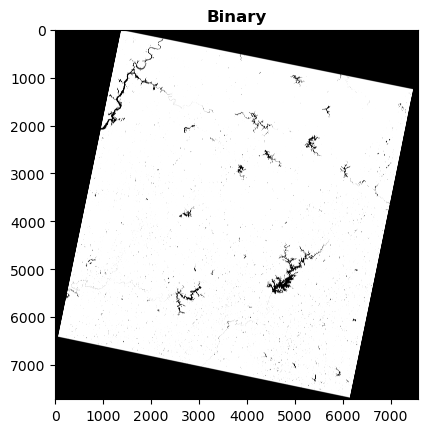

In [5]:
inter_results = {'Top-Hat':top_hat,
                 'Bottom hat':bottom_hat,
                 'White & Bottom hat': white_bottom_hat,
                 'Opening':openend,
                 'Dilatation':dilated,
                 'Binary':binary}

for key, values in inter_results.items():
    plot.show(values, cmap='gray',title=key)

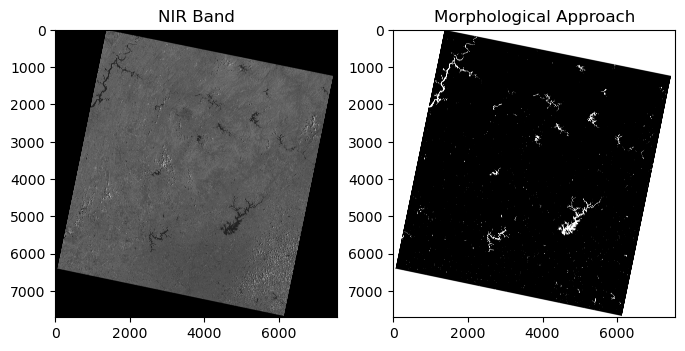

In [6]:
# Final result
plot_comparison(b5,final_output,'Morphological Approach',cmap='gray_r')

### Index Approach

In [7]:
with rasterio.open('LC08_L2SP_019036_20210728_20210804_02_T1_SR_B3.TIF','r') as data:
    b3 = np.squeeze(data.read()) 

In [8]:
def ndwi_binary(green_band:np.array, 
                nir_band:np.array) -> np.array:     
    """
    Return a NDWI classification in binary form 
    """
    # Allowing division by zero
    np.seterr(divide='ignore', invalid='ignore')
    
    # NDWI
    ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
    
    return ndwi, np.where(ndwi <= 0.015, 0, 1)

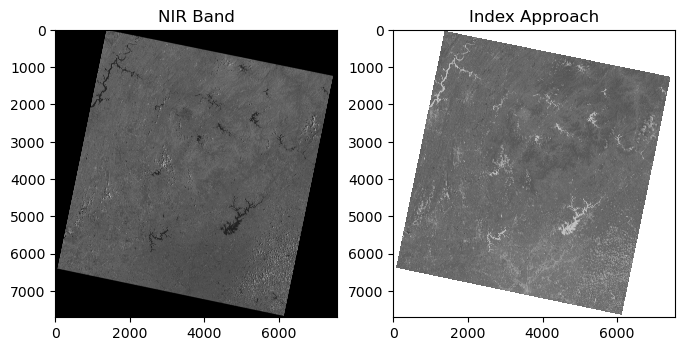

In [9]:
ndwi, index_approach = ndwi_binary(b3,b5)
plot_comparison(b5,ndwi,'Index Approach')

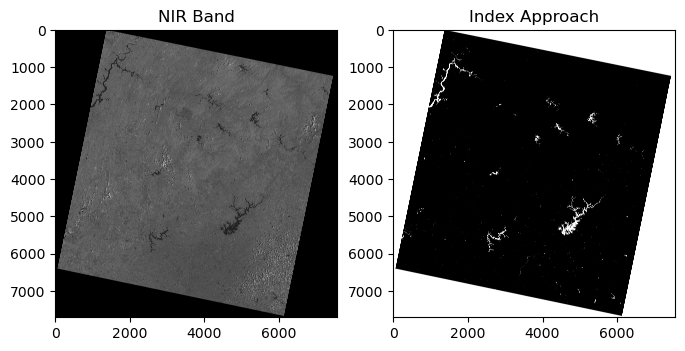

In [10]:
plot_comparison(b5,index_approach,'Index Approach')

### Discussion

**Pros**
- According to the authors, the Mathematical Morphological approach performed better in all testing areas (accuracy, F1 and MCC scores) in comparison to the index approach;

- Reproducibility for several datasets with different resolutions;

- The shape of the target element is preserved;

- Apparently less confusion with clouds;

**Cons**
- The processing time of the algorithm relies on the size of the structural element and the number of pixels in the image. 

- It is not very well explained how to find the optimal SE size. Besides mentioning that the 3 SE sizes for the datasets types should not be higher than 20 pixels, the authors do not mention which exact SE size they chose for each resolution.